<a href="https://colab.research.google.com/github/akshay8867/Exploratory-Data-Analysis-Practice/blob/main/Filtered_Flight_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)    

/content/drive
Mounted at /content/drive


## The data can be downloaded from the following link to follow along with the worksheet
 **https://www.kaggle.com/nikhilmittal/flight-fare-prediction-mh** 

In [132]:
import pandas as pd
df_train=pd.read_excel(r'/content/drive/MyDrive/Flight_Price/Flight_Price/Data_Train.xlsx')
df_train.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [66]:
df_test=pd.read_excel(r'/content/drive/MyDrive/Flight_Price/Flight_Price/Test_set.xlsx')
df_test.shape

(2671, 10)

In [ ]:
df_train.info()

## **Checking for the outlier in the target variable**

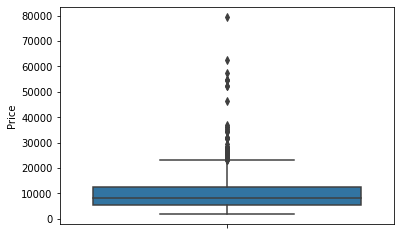

In [28]:
import seaborn as sns
sns.boxplot(data=df_train,y='Price')

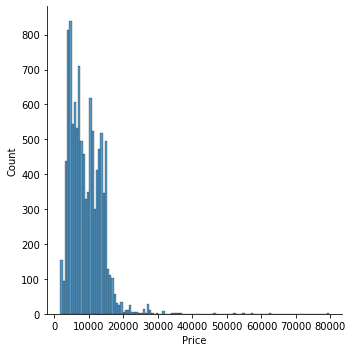

In [29]:
sns.displot(data=df_train,x='Price')

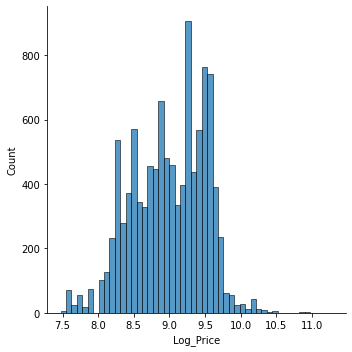

In [67]:
import numpy as np
df_train['Log_Price']=np.log1p(df_train['Price'])
sns.displot(data=df_train,x='Log_Price')


In [32]:
import scipy.stats as stat
import pylab

def plot_data(df,feature):
    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    df[feature].hist()
    plt.subplot(1,2,2)
    stat.probplot(df[feature],dist='norm',plot=pylab)
    plt.show()

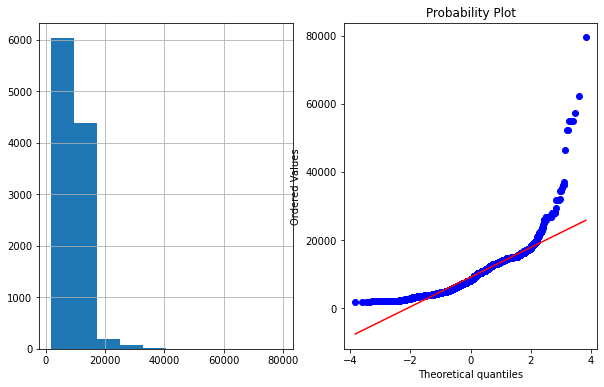

In [48]:
plot_data(df_train,'Price')

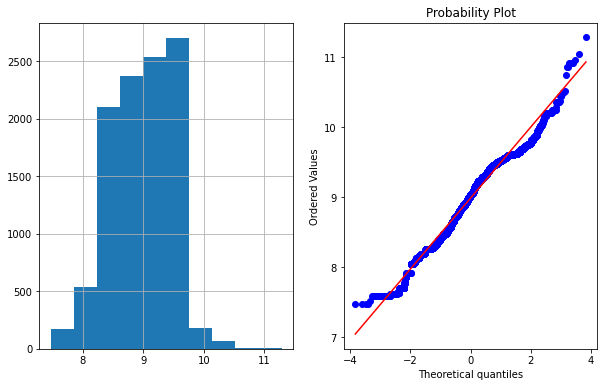

In [33]:
plot_data(df_train,'Log_Price')

### **From the above graph we can see that our target variable is normally distributed now**

In [40]:
import matplotlib.pyplot as plt
def explore_cat_variable(df,col,target,aggre):
  
    print("Variation of {} with {} variable".format(" ".join(col),target))
    print(df.groupby(col)[target].agg(aggre).plot.bar())
    plt.show()
    print("*"*75)
    print("Summary of statisitcs grouped at level {} wrt to {}".format(" ".join(col),target))
    print(df.groupby(col)[target].describe())



Variation of Airline with Price variable
AxesSubplot(0.125,0.125;0.775x0.755)


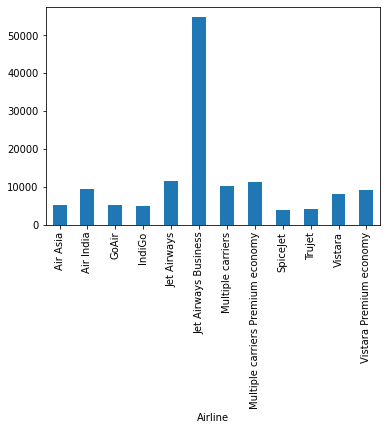

***************************************************************************
Summary of statisitcs grouped at level Airline wrt to Price
                                    count          mean  ...       75%      max
Airline                                                  ...                   
Air Asia                            319.0   5590.260188  ...   6451.00  13774.0
Air India                          1752.0   9611.210616  ...  12219.00  31945.0
GoAir                               194.0   5861.056701  ...   6811.25  22794.0
IndiGo                             2053.0   5673.682903  ...   6494.00  22153.0
Jet Airways                        3849.0  11643.923357  ...  14151.00  54826.0
Jet Airways Business                  6.0  58358.666667  ...  61122.50  79512.0
Multiple carriers                  1196.0  10902.678094  ...  13587.00  36983.0
Multiple carriers Premium economy    13.0  11418.846154  ...  11269.00  14629.0
SpiceJet                            818.0   4338.284841  ...   4

In [41]:
explore_cat_variable(df_train,['Airline'],'Price','median')

**- Jet Airways offers the tickets at a high price consistently**


Variation of Source Destination with Price variable
AxesSubplot(0.125,0.125;0.775x0.755)


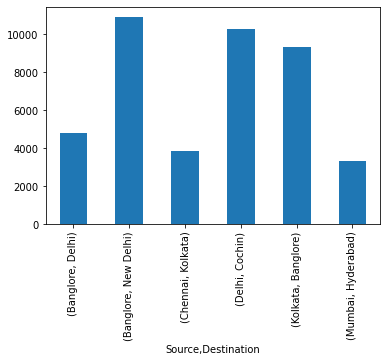

***************************************************************************
Summary of statisitcs grouped at level Source Destination wrt to Price
                       count          mean  ...      75%      max
Source   Destination                        ...                  
Banglore Delhi        1265.0   5143.918577  ...   5911.0   8541.0
         New Delhi     932.0  11917.716738  ...  13817.0  79512.0
Chennai  Kolkata       381.0   4789.892388  ...   5277.0  19630.0
Delhi    Cochin       4537.0  10539.439057  ...  13344.0  52285.0
Kolkata  Banglore     2871.0   9158.389411  ...  12681.0  31945.0
Mumbai   Hyderabad     697.0   5059.708752  ...   5678.0  25139.0

[6 rows x 8 columns]


In [133]:
explore_cat_variable(df_train,['Source','Destination'],'Price','median')

- **The tickets for Bangalore to Delhi is the most expensive over the observed timespan while flights from Mumbai to Hyderabad are the cheapest**
- **This also helps to infer that viewing the source column and the destination column won't make much sense and thus viewing them in combinatio will help us to obtain more insights**
- **On the basis of this chart, I decided to combine the source and destination into a new column and then one hot encode them using pd.get_dummies function**

## Observation on Arrival and Departure Time
Since Arrival and departure time influence the price fo the flight so I decided to make bins of the arrival and departure time into the following categories
- **Midnight Early (12 am to 6 am)**
- **Early Noon (6am to 12pm)**
- **Noon Evening (12pm to 6pm)**
- **Evening Midnigh (6pm to 12 am)** 

*We will add these bins to see if the model performance improves or not*

In [ ]:
def make_bins(x):
  if x <= 6:
    return "Midnight_Early"
  elif x >6 and x <=12:
    return "Early_Noon"
  elif x >12 and x <=18:
    return "Noon-Evening"
  else:
    return "Evening-Night"

In [54]:
def add_features(df,col):
  # df['year'] = pd.DatetimeIndex(df[col]).year
  # df['weekday'] = pd.DatetimeIndex(df[col]).weekday
  df['day'] = pd.DatetimeIndex(df[col]).day
  df['quarter'] = pd.DatetimeIndex(df[col]).quarter
  df['month'] = pd.DatetimeIndex(df[col]).month
  df.drop(labels=[col],inplace=True,axis=1)
  

In [43]:
def add_time_features(df,col):
  for m in col:
    df[m]=df[m].apply(lambda x: x.split(":")[0])
    df[m]=df[m].astype(int)
    

In [53]:
def transform_duration(x):
  try:
    if 'h' in x and 'm' in x:
      return int(x.split(" ")[0][:-1]) + int(x.split(" ")[1][:-1])/60

    elif x[-1]=='m':
      return int(x.split(" ")[0][:-1])/60
    else:
      return int(x.split(" ")[0][:-1])
  except Exception as e:
    print(x)

In [56]:
def transform_duration(df,col):
  df[col]=df[col].map(transform_time)

### **Handling Categorical variables for Test and Train data together**

In [ ]:
df_train.dropna(axis=0,inplace=True)
add_features(df_train,'Date_of_Journey')
add_features(df_test,'Date_of_Journey')
transform_duration(df_train,'Duration')
transform_duration(df_test,'Duration')
df_train['Source_Destination']=df_train['Source']+"_"+df_train['Destination']
df_test['Source_Destination']=df_test['Source']+"_"+df_test['Destination']
df_train=pd.get_dummies(df_train,columns=['Source_Destination'],drop_first=True)
df_test=pd.get_dummies(df_test,columns=['Source_Destination'],drop_first=True)
df_train=pd.get_dummies(df_train,columns=['Airline'],drop_first=True)
df_test=pd.get_dummies(df_test,columns=['Airline'],drop_first=True)
df_test['Airline_Trujet']=0
stops_dict={'non-stop':1, '2 stops':3, '1 stop':2, '3 stops':4, '4 stops':5}
df_train['Total_Stops']=df_train['Total_Stops'].map(stops_dict)

df_train.drop(labels=['Route','Source','Destination','Additional_Info'],axis=1,inplace=True)
df_test.drop(labels=['Route','Source','Destination','Additional_Info'],axis=1,inplace=True)


In [72]:
X=df_train.drop(labels=['Price','Log_Price'],axis=1)
y=df_train['Log_Price']
print(len(X.columns))
print(len(df_test.columns))

## **Preparing train and test split for Xgboost regressor**

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [93]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:linear',
}

## **Initial Regressor model with baseline parameters**

In [92]:
params['eval_metric'] = "rmse"
num_boost_round = 999
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

## **Performing cross validation**

In [96]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=10
)
cv_results

[21:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,5.958854,0.001533,5.958976,0.007110
1,4.177810,0.001073,4.178502,0.006044
2,2.931866,0.000734,2.932465,0.006023
3,2.061366,0.000556,2.062020,0.005921
4,1.454199,0.000438,1.455083,0.005860
...,...,...,...,...
101,0.126119,0.001643,0.174731,0.001840
102,0.125802,0.001731,0.174646,0.001813
103,0.125448,0.001749,0.174606,0.001837
104,0.125182,0.001802,0.174570,0.001847


In [98]:
cv_results['test-rmse-mean'].min()

0.174491

# **Hyperparameter tuning**

### **I followed the approach shared in the article: https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f to perform hyperparameter tuning on thr XGBoost Regressor model**

### **Parameters max_depth and min_child_weight**
These parameters add constraints on the architecture of the trees.
**max_depth** is the maximum number of nodes allowed from the root to the farthest leaf of a tree. Deeper trees can model more complex relationships by adding more nodes, but as we go deeper, splits become less relevant and are sometimes only due to noise, causing the model to overfit.
**min_child_weight** is the minimum weight (or number of samples if all samples have a weight of 1) required in order to create a new node in the tree. A smaller min_child_weight allows the algorithm to create children that correspond to fewer samples, thus allowing for more complex trees, but again, more likely to overfit.
Thus, those parameters can be used to control the complexity of the trees. It is important to tune them together in order to find a good trade-off between model bias and variance

In [100]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

In [103]:
min_rmse = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_rmse))

CV with max_depth=9, min_child_weight=5
[21:08:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:08:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:08:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:08:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:08:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 0.1807474 for 34 rounds
CV with max_depth=9, min_child_weight=6
[21:08:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:08:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[2

In [104]:
params['max_depth'] = 9
params['min_child_weight'] = 7

### **Parameters subsample and colsample_bytree**
These parameters control the sampling of the dataset that is done at each boosting round.
Instead of using the whole training set every time, we can build a tree on slightly different data at each step, which makes it less likely to overfit to a single sample or feature.
subsample corresponds to the fraction of observations (the rows) to subsample at each step. By default it is set to 1 meaning that we use all rows.
colsample_bytree corresponds to the fraction of features (the columns) to use. By default it is set to 1 meaning that we will use all features.
Let’s see if we can get better results by tuning those parameters together.

In [107]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [109]:
min_rmse = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (subsample,colsample)
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

CV with subsample=1.0, colsample=1.0
[21:12:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:12:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:12:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:12:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:12:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 0.17996700000000002 for 35 rounds
CV with subsample=1.0, colsample=0.9
[21:12:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:12:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror

In [110]:
params['subsample'] = 1
params['colsample_bytree'] = 0.7

## **Parameter ETA**
The ETA parameter controls the learning rate. It corresponds to the shrinkage of the weights associated to features after each round, in other words it defines the amount of "correction" we make at each step

In [113]:
%time
# This can take some time…
min_rmse = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    %time 
    cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            seed=42,
            nfold=5,
            metrics=['rmse'],
            early_stopping_rounds=10
          )
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds\n".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = eta
print("Best params: {}, RMSE: {}".format(best_params, min_rmse))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
CV with eta=0.3
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.77 µs
[21:17:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:17:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:17:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:17:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:17:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	RMSE 0.178282 for 42 rounds

CV with eta=0.2
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs
[21:17:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg

In [114]:
params

{'colsample_bytree': 0.7,
 'eta': 0.005,
 'eval_metric': 'rmse',
 'max_depth': 9,
 'min_child_weight': 7,
 'objective': 'reg:linear',
 'subsample': 1}

In [115]:
params['eta']=0.01
params

{'colsample_bytree': 0.7,
 'eta': 0.01,
 'eval_metric': 'rmse',
 'max_depth': 9,
 'min_child_weight': 7,
 'objective': 'reg:linear',
 'subsample': 1}

## **Training the model with the updated param dictionary**

In [116]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[21:20:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-rmse:8.42111
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:8.33705
[2]	Test-rmse:8.25384
[3]	Test-rmse:8.17151
[4]	Test-rmse:8.08995
[5]	Test-rmse:8.00923
[6]	Test-rmse:7.92931
[7]	Test-rmse:7.8502
[8]	Test-rmse:7.77186
[9]	Test-rmse:7.69431
[10]	Test-rmse:7.61755
[11]	Test-rmse:7.54154
[12]	Test-rmse:7.46631
[13]	Test-rmse:7.39181
[14]	Test-rmse:7.31807
[15]	Test-rmse:7.24507
[16]	Test-rmse:7.17279
[17]	Test-rmse:7.10123
[18]	Test-rmse:7.03041
[19]	Test-rmse:6.96026
[20]	Test-rmse:6.89089
[21]	Test-rmse:6.82217
[22]	Test-rmse:6.75413
[23]	Test-rmse:6.68675
[24]	Test-rmse:6.62006
[25]	Test-rmse:6.55406
[26]	Test-rmse:6.48872
[27]	Test-rmse:6.424
[28]	Test-rmse:6.35989
[29]	Test-rmse:6.29642
[30]	Test-rmse:6.23363
[31]	Test-rmse:6.17144
[32]	Test-rmse:6.10984
[33]	Test-rmse:6.04893
[34]	Test-rmse:5.98859
[35]	Test-rmse:5.92889
[

In [117]:
print("Best rmse: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))

Best rmse: 0.17 in 997 rounds


In [121]:
X_test

,Dep_Time,Arrival_Time,Duration,Total_Stops,day,quarter,month,Source_Destination_Banglore_New Delhi,Source_Destination_Chennai_Kolkata,Source_Destination_Delhi_Cochin,Source_Destination_Kolkata_Banglore,Source_Destination_Mumbai_Hyderabad,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy
6075,15,1,10.416667,3,21,2,5,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
3544,10,19,9.000000,2,6,1,3,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
9291,20,9,12.750000,2,5,3,9,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
5032,14,17,2.333333,1,24,2,5,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2483,22,4,5.583333,2,21,2,5,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9797,8,21,13.000000,2,27,2,6,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
9871,17,19,2.500000,1,3,2,6,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
10063,7,22,14.500000,2,21,2,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
8802,6,23,16.916667,2,24,1,3,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0


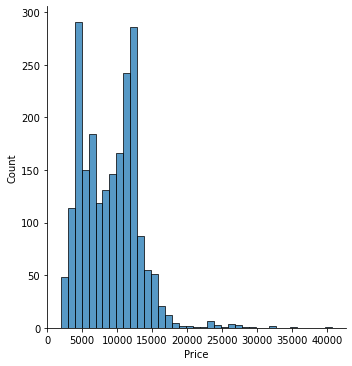

In [131]:
predictions=np.exp(model.predict(dtest))
ax=sns.displot(predictions)
ax.set(xlabel='Price')

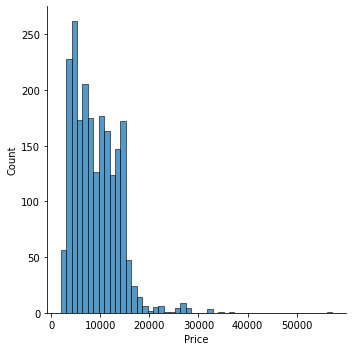

In [130]:
ax=sns.displot(np.exp(y_test))
ax.set(xlabel='Price')
plt.show()

In [129]:
from sklearn.metrics import r2_score
r2_score(np.exp(y_test),predictions)

0.8118123787138346

## **We get R2 score of 81% which highlights our features were able to capture the 81% of variance in the ticket prices**